<div style="background-color: #ADD8E6; border: 1px solid gray; padding: 3px">
    This notebook consists of 2 agentic workflows:
        <h3>Data Generation Workflow</h3>
        <li><b>Data Augmentation</b>: Augments the provided image dataset.</li>
        <h3>Validation Workflow</h3>
        <li><b>Image Validator</b>: Identifies whether a valid driver's license exists in the given image.</li>
        <li><b>Data Extractor</b>: Extracts relevant metadata from the image.</li>
        <li><b>Application Validator</b>: Given the extracted metadata associated with the application, uses a set of predefined rules to validate the driver's license application.</li>
</div>

In [1]:
##############################################################################
# Imports
##############################################################################
# import pysqlite3 as sqlite3
# import sys
# sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import operator
from typing import Annotated, TypedDict, List, Optional, Literal
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from PIL import Image
import pytesseract
import io
import json
from datetime import datetime
import re
import os
import requests
from flow_extensions import CustomLLMMultimodalBlock, CustomDeleteColumnsBlock
from io import BytesIO
from dotenv import load_dotenv
import mimetypes
import base64
from urllib.parse import urlparse
from PIL import Image
from io import BytesIO
import requests
load_dotenv()
import traceback
from openai import OpenAI
import instructor
from pydantic import BaseModel, Field, TypeAdapter
from more_itertools import chunked
import utils
from datasets import load_dataset, DatasetDict, Dataset
from sdg_hub.core.flow import FlowRegistry, Flow
import pandas as pd
from typing import Any, Optional
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [2]:
##############################################################################
# State Definitions
##############################################################################

class LicenseState(TypedDict):
    """Enhanced state definition"""

    github_repo: str

    github_subfolder: str

    vision_model: str

    analytics_data: pd.DataFrame

    messages: Annotated[List[BaseMessage], add_messages]

In [3]:
##############################################################################
# Structured Output
##############################################################################

class DriversLicenseField(BaseModel):
    
    value: str = Field("", description="Name of field")
    
    missing_error_reason: str = Field("", description="Reason for missing field")

    is_valid: Optional[bool] = Field(None, description="Indicates whether the license is valid.")
    
    application_value: str = Field("", description="Value of the corresponding field in the application")
    
    invalid_error_reason: str = Field("", description="Reason for invalid field")

    

class DriversLicenseMetadata(BaseModel):

    application_id: str = Field("", description="Unique identifier")

    model: str = Field("", description="Name of LLM used to generate metadata")
    
    name: DriversLicenseField = Field(description="Name of driver's license owner")
    
    date_of_birth: DriversLicenseField = Field(description="Date of birth of driver's license owner")
    
    expiration_date: DriversLicenseField = Field(description="Expiration date of driver's license")
    
    state_issued: DriversLicenseField = Field(description="State where the license was issued")
    
    issuance_date: DriversLicenseField = Field(description="Date when the license was issued")

    photo_orientation: DriversLicenseField = Field("", description="The skew of the license in the photo")

class LicenseApplication(BaseModel):

    application_id: str = Field(description="Unique identifier")

    image_path: str = Field(description="Image path")

    application_data: dict = Field(description="Submitted application data")
    

In [4]:
##############################################################################
# Tools
##############################################################################

def image_to_base64(image_path, encode_image_bytes=False):
    """Transforms image at provided local path or URL into base64-encoded representation."""
    
    def is_valid_http_url(input_path):
        """Returns whether or not the input is a valid URL."""
    
        parsed_url = urlparse(input_path)
    
        is_http_url = all([parsed_url.scheme in ('http', 'https'), parsed_url.netloc])
    
        return is_http_url
        
    
    try:
        start_time = datetime.now()
    
        mime_type, _ = mimetypes.guess_type(image_path)
    
        if "image" in mime_type:
    
            if encode_image_bytes:
    
                if is_valid_http_url(image_path):
        
                    response = requests.get(image_path)
    
                    response.raise_for_status()
    
                    stream_to_read = response.content
    
                else:
                    
                    with open(image_path, "rb") as image_file:
                        
                        stream_to_read = image_file.read()
    
                img = base64.b64encode(stream_to_read).decode("utf-8")
        
                return f"data:{mime_type};base64,{img}"
    
            else:
    
                return image_path
                
    
        else:
    
            raise Exception(f"Mime type {mime_type} not supported")
        
        processing_time = (datetime.now() - start_time).total_seconds()
        
        print(f"Image loaded: time: {processing_time:.2f}s")
            
    except Exception as e:
        
        error_msg = f"Image loading error: {str(e)}"
    
        print(f"- {error_msg}")

        traceback.print_exc()
    
    return None

In [5]:
##############################################################################
# Nodes
##############################################################################

def load_and_convert_from_github(state: LicenseState) -> LicenseState:
    """Converts the images in the provided github repo folder into a paired representation of images and their applications."""
    print("✓ STEP 1: Conversion of Github Repositories into a paired image-to-application representation")
    
    print("="*60)
    
    ############################################################################################################################
    # Group the files by ID
    ############################################################################################################################
    applications = utils.group_files_by_id(state["github_repo"], state["github_subfolder"])

    ############################################################################################################################
    # Use static rules to transform the data into specifically identified submitted fields
    ############################################################################################################################
    submitted_fields = utils.convert_to_submitted_fields(applications, "patterns.json")

    ############################################################################################################################
    # Represent the files as a dataframe
    ############################################################################################################################
    df = pd.DataFrame(submitted_fields)
    
    return {
        "analytics_data" : df,
        "messages": [AIMessage(content="License applications retrieved from github and converted.")]
    }

def validate_extracted_data(state: LicenseState) -> LicenseState:
    """Extracts the drivers license data from the images in the provided git repository."""

    print("✓ STEP 2: AI-Powered Data Extraction")
    
    print("="*60)

    ############################################################################################################################
    # Retrieve the application data
    ############################################################################################################################
    df = state["analytics_data"]

    ############################################################################################################################
    # Add the current model
    ############################################################################################################################
    model_prefix = state["vision_model"]
    
    df["model_name"] = os.getenv(f"{model_prefix}_LLM_NAME")

    ############################################################################################################################
    # Build a dataset for sdg_hub
    ############################################################################################################################
    dataset = Dataset.from_pandas(df)

    ############################################################################################################################
    # Run sdg_hub
    ############################################################################################################################
    flow_path = "flows/drivers_license_validation/flow.yaml"
    
    flow = Flow.from_yaml(flow_path)
    
    flow.set_model_config(
        model=os.getenv(f"{model_prefix}_LLM_NAME"),
        api_base=os.getenv(f"{model_prefix}_LLM_BASE"),
        api_key=os.getenv(f"{model_prefix}_LLM_KEY"),
        temperature=0,
        
        max_tokens = 8192,
        response_format={"type": "json_object"},
        top_k=1,
    )

    converted_dataset = flow.generate(dataset, max_concurrency=10)
    
    converted_df = converted_dataset.to_pandas()

    state["analytics_data"] = converted_df

    return {
        "analytics_data" : converted_df,
        "messages": [AIMessage(content="License data extracted.")]
    }


def generate_report(state: LicenseState) -> LicenseState:
    """Node: Generate reports"""
    print("✓ STEP 4: Compiling Final Results")
    
    print("="*60)

    ############################################################################################################################
    # Serialize the application data to a file
    ############################################################################################################################

    df = state["analytics_data"]
    
    utils.generate_jsonl_report(df, f"reports_{state['vision_model']}")
    
    return {"messages": [HumanMessage(content="DONE")]}

In [6]:
##############################################################################
# Graph
##############################################################################
def create_license_extraction_graph():
    """Create the LangGraph workflow"""
    workflow = StateGraph(LicenseState)
    
    # Add all nodes
    workflow.add_node("load_from_github", load_and_convert_from_github)
    
    workflow.add_node("validate_data", validate_extracted_data)
    
    workflow.add_node("generate_report", generate_report)
    
    # Define edges
    workflow.add_edge(START, "load_from_github")
    
    workflow.add_edge("load_from_github", "validate_data")
    
    workflow.add_edge("validate_data", "generate_report")
    
    workflow.add_edge("generate_report", END)
    
    return workflow.compile()

In [7]:
##############################################################################
# Execute the Flow
##############################################################################

def extract_license_info(github_repo: str, github_subfolder: str, vision_model: str) -> pd.DataFrame:
    """
    Main extraction function
    """

    start_time = datetime.now()

    print(f"Started pipeline: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

    initial_state = {
        "github_repo": github_repo,

        "github_subfolder": github_subfolder,

        "vision_model": model_prefix,

        "messages": [HumanMessage(f"Validate driver's license data for {model_prefix} model...")]
        
    }

    graph = create_license_extraction_graph()
            
    # final_state = app.invoke(initial_state)

    config = {"configurable": {"thread_id": 42, "recursion_limit": 5}}

    stream = graph.stream(initial_state, config, stream_mode="values")

    for event in stream:
        last_message = event['messages'][-1]
        
        last_message.pretty_print()

        if "DONE" in last_message.content:

            return event["analytics_data"]

### Execute Code Translation Flow
Execute the flow!

Started pipeline: 2025-11-24 22:05:29
================================ Human Message =================================

Validate driver's license data for LLAMASCOUT4 model...
✓ STEP 1: Conversion of Github Repositories into a paired image-to-application representation
================================== Ai Message ==================================

License applications retrieved from github and converted.
✓ STEP 2: AI-Powered Data Extraction


[22:05:31] INFO     Loading flow from: flows/drivers_license_validation/flow.yaml                       ]8;id=992631;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=181811;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#140\140]8;;\

           INFO     Auto-detected 2 LLM blocks for configuration: ['eval_data_from_image',              ]8;id=566557;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=32645;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#825\825]8;;\
                    'extract_data_from_image']                                                                     

           INFO     Successfully configured 2 LLM blocks with: model:                                   ]8;id=185455;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=285447;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#867\867]8;;\
                    'openrouter/meta-llama/llama-4-scout', api_base: 'https://openrouter.ai/api/v1',               
                    api_key: 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,            
                    temperature: 0, max_tokens: 8192, response_format: {'type': 'json_object'}, top_k:             
                    1                                                                                              

           INFO     Configured blocks: ['eval_data_from_image', 'extract_data_from_image']              ]8;id=874448;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=470280;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#870\870]8;;\

           INFO     Converting datasets.Dataset to pd.DataFrame for processing                          ]8;id=778109;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=576226;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#307\307]8;;\

           INFO     Using max_concurrency=10 for LLM requests                                           ]8;id=309100;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=507432;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#454\454]8;;\

           INFO     Starting flow 'Drivers License Validation' v1.0.0 with 10 samples across 9 blocks   ]8;id=391109;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=606384;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#490\490]8;;\
                    (max_concurrency=10)                                                                           

           INFO     Executing block 1/9: extract_data_from_image_prompt (PromptBuilderBlock)            ]8;id=187448;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=704384;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭──────────────────────────────────────── extract_data_from_image_prompt ─────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: PromptBuilderBlock                                                                                  │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 8                                                                                                │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name                                                                                                      │
│ Expected Output Columns: data_from_image_prompt                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────── extract_data_from_image_prompt - Complete ───────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 8 → 9                                                                                                  │
│ 🟢 Added: data_from_image_prompt                                                                                │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, expiration_date,            │
│ image_path, model_name, name, state_issued                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'extract_data_from_image_prompt' completed successfully: 10 samples, 9        ]8;id=123532;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=245289;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 2/9: extract_data_from_image (CustomLLMMultimodalBlock)             ]8;id=883997;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=984912;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭──────────────────────────────────────────── extract_data_from_image ────────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: CustomLLMMultimodalBlock                                                                            │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 9                                                                                                │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt                                                                              │
│ Expected Output Columns: extracted_data_full                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:05:31] INFO     Starting async generation for 10 samples (max_concurrency=10)             ]8;id=168155;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py\llm_chat_block.py]8;;\:]8;id=210539;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py#209\209]8;;\

[22:05:35] INFO     Generation completed successfully for 10 samples                          ]8;id=290461;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py\llm_chat_block.py]8;;\:]8;id=943702;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py#262\262]8;;\

╭────────────────────────────────────── extract_data_from_image - Complete ───────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 9 → 10                                                                                                 │
│ 🟢 Added: extracted_data_full                                                                                   │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, expiration_date,            │
│ extracted_data_full, image_path, model_name, name, state_issued                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:05:35] INFO     Block 'extract_data_from_image' completed successfully: 10 samples, 10 columns      ]8;id=239560;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=593467;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\

           INFO     Executing block 3/9: extract_json_data_from_output (LLMParserBlock)                 ]8;id=847073;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=286544;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭───────────────────────────────────────── extract_json_data_from_output ─────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: LLMParserBlock                                                                                      │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 10                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full                                                         │
│ Expected Output Columns: extract_json_data_from_output_content, extract_json_data_from_output_reasoning_content │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:05:35] WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=276302;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=935890;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=318715;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=693535;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=488563;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=598369;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=20024;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=225175;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=488387;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=21998;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=530306;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=334316;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=980979;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=325817;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=185835;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=28977;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=155734;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=311494;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=921276;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=682870;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

╭─────────────────────────────────── extract_json_data_from_output - Complete ────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 10 → 11                                                                                                │
│ 🟢 Added: extract_json_data_from_output_content                                                                 │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, expiration_date,            │
│ extract_json_data_from_output_content, extracted_data_full, image_path, model_name, name, state_issued          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'extract_json_data_from_output' completed successfully: 10 samples, 11        ]8;id=458810;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=382397;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 4/9: extract_json_data_from_output_text (TextParserBlock)           ]8;id=968908;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=442255;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭────────────────────────────────────── extract_json_data_from_output_text ───────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: TextParserBlock                                                                                     │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 11                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content                  │
│ Expected Output Columns: extracted_data                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────── extract_json_data_from_output_text - Complete ─────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 11 → 12                                                                                                │
│ 🟢 Added: extracted_data                                                                                        │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, expiration_date,            │
│ extract_json_data_from_output_content, extracted_data, extracted_data_full, image_path, model_name, name,       │
│ state_issued                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'extract_json_data_from_output_text' completed successfully: 10 samples, 12   ]8;id=928886;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=686185;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 5/9: evaluate_data_from_image_prompt (PromptBuilderBlock)           ]8;id=395421;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=318999;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭──────────────────────────────────────── evaluate_data_from_image_prompt ────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: PromptBuilderBlock                                                                                  │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 12                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data  │
│ Expected Output Columns: eval_from_image_prompt                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── evaluate_data_from_image_prompt - Complete ───────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 12 → 13                                                                                                │
│ 🟢 Added: eval_from_image_prompt                                                                                │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, eval_from_image_prompt,     │
│ expiration_date, extract_json_data_from_output_content, extracted_data, extracted_data_full, image_path,        │
│ model_name, name, state_issued                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'evaluate_data_from_image_prompt' completed successfully: 10 samples, 13      ]8;id=825;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=151790;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 6/9: eval_data_from_image (LLMChatBlock)                            ]8;id=652358;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=814951;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭───────────────────────────────────────────── eval_data_from_image ──────────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: LLMChatBlock                                                                                        │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 13                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data, │
│ eval_from_image_prompt                                                                                          │
│ Expected Output Columns: extracted_eval_full                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Starting async generation for 10 samples (max_concurrency=10)             ]8;id=802250;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py\llm_chat_block.py]8;;\:]8;id=345295;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py#209\209]8;;\

[22:05:36] INFO     Generation completed successfully for 10 samples                          ]8;id=518267;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py\llm_chat_block.py]8;;\:]8;id=683655;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py#262\262]8;;\

╭──────────────────────────────────────── eval_data_from_image - Complete ────────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 13 → 14                                                                                                │
│ 🟢 Added: extracted_eval_full                                                                                   │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, eval_from_image_prompt,     │
│ expiration_date, extract_json_data_from_output_content, extracted_data, extracted_data_full,                    │
│ extracted_eval_full, image_path, model_name, name, state_issued                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:05:36] INFO     Block 'eval_data_from_image' completed successfully: 10 samples, 14 columns         ]8;id=341877;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=169070;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\

           INFO     Executing block 7/9: eval_json_data_from_output (LLMParserBlock)                    ]8;id=429402;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=925671;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭────────────────────────────────────────── eval_json_data_from_output ───────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: LLMParserBlock                                                                                      │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 14                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data, │
│ eval_from_image_prompt, extracted_eval_full                                                                     │
│ Expected Output Columns: eval_json_data_from_output_content, eval_json_data_from_output_reasoning_content       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:05:36] WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=896894;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=903854;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=969955;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=761708;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=257986;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=106437;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=772264;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=345550;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=435985;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=630639;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=659028;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=904859;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=108508;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=223147;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=732700;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=888225;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=691075;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=424579;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=563733;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=887068;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

╭───────────────────────────────────── eval_json_data_from_output - Complete ─────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 14 → 15                                                                                                │
│ 🟢 Added: eval_json_data_from_output_content                                                                    │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, eval_from_image_prompt,     │
│ eval_json_data_from_output_content, expiration_date, extract_json_data_from_output_content, extracted_data,     │
│ extracted_data_full, extracted_eval_full, image_path, model_name, name, state_issued                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'eval_json_data_from_output' completed successfully: 10 samples, 15 columns   ]8;id=111668;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=888890;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\

           INFO     Executing block 8/9: eval_json_data_from_output_text (TextParserBlock)              ]8;id=555971;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=487032;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭──────────────────────────────────────── eval_json_data_from_output_text ────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: TextParserBlock                                                                                     │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 15                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data, │
│ eval_from_image_prompt, extracted_eval_full, eval_json_data_from_output_content                                 │
│ Expected Output Columns: eval_data                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── eval_json_data_from_output_text - Complete ───────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 15 → 16                                                                                                │
│ 🟢 Added: eval_data                                                                                             │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, eval_data,                  │
│ eval_from_image_prompt, eval_json_data_from_output_content, expiration_date,                                    │
│ extract_json_data_from_output_content, extracted_data, extracted_data_full, extracted_eval_full, image_path,    │
│ model_name, name, state_issued                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'eval_json_data_from_output_text' completed successfully: 10 samples, 16      ]8;id=683093;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=386345;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 9/9: drop_fields (CustomDeleteColumnsBlock)                         ]8;id=869408;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=56073;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭────────────────────────────────────────────────── drop_fields ──────────────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: CustomDeleteColumnsBlock                                                                            │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 16                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data, │
│ eval_from_image_prompt, extracted_eval_full, eval_json_data_from_output_content, eval_data                      │
│ Expected Output Columns: None specified                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── drop_fields - Complete ─────────────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 16 → 10                                                                                                │
│ 🔴 Removed: data_from_image_prompt, eval_from_image_prompt, eval_json_data_from_output_content,                 │
│ extract_json_data_from_output_content, extracted_data_full, extracted_eval_full                                 │
│ 📋 Final Columns: application_id, date_of_birth, dl_number, eval_data, expiration_date, extracted_data,         │
│ image_path, model_name, name, state_issued                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'drop_fields' completed successfully: 10 samples, 10 columns                  ]8;id=344213;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=554426;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\

╭───────────────────────────────────── Drivers License Validation - Complete ─────────────────────────────────────╮
│                                        Flow Execution Summary                                                   │
│ ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓           │
│ ┃ Block Name           ┃ Type            ┃   Duration ┃     Rows     ┃     Columns     ┃   Status   ┃           │
│ ┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩           │
│ │ extract_data_from_i… │ PromptBuilderB… │      0.01s │   10 → 10    │       +1        │     ✓      │           │
│ │ extract_data_from_i… │ CustomLLMMulti… │      4.04s │   10 → 10    │       +1        │     ✓      │           │
│ │ extract_json_data_f… │ LLMParserBlock  │      0.03s │   10 → 10    │       +1        │     ✓      │           │
│ │ extract_json_data_f… │ TextParserBlock │      0.01s │   10 → 10    │       +1        │     ✓      │           │
│ │ evaluate_data_from_… │ PromptBuilderB… │      0.01s │   10 → 10    │       +1        │     ✓      │           │
│ │ eval_data_from_image │ LLMChatBlock    │      1.65s │   10 → 10    │       +1        │     ✓      │           │
│ │ eval_json_data_from… │ LLMParserBlock  │      0.02s │   10 → 10    │       +1        │     ✓      │           │
│ │ eval_json_data_from… │ TextParserBlock │      0.01s │   10 → 10    │       +1        │     ✓      │           │
│ │ drop_fields          │ CustomDeleteCo… │      0.00s │   10 → 10    │       -6        │     ✓      │           │
│ ├──────────────────────┼─────────────────┼────────────┼──────────────┼─────────────────┼────────────┤           │
│ │ TOTAL                │ 9 blocks        │      5.77s │   10 final   │    10 final     │    9/9     │           │
│ └──────────────────────┴─────────────────┴────────────┴──────────────┴─────────────────┴────────────┘           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Flow 'Drivers License Validation' completed successfully: 10 final samples, 10      ]8;id=20031;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=982997;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#593\593]8;;\
                    final columns                                                                                  

           INFO     Converting pd.DataFrame back to datasets.Dataset to match input type                ]8;id=415662;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=240699;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#330\330]8;;\

================================== Ai Message ==================================

License data extracted.
✓ STEP 4: Compiling Final Results
================================ Human Message =================================

DONE
Started pipeline: 2025-11-24 22:05:37
================================ Human Message =================================

Validate driver's license data for GEMMA27B model...
✓ STEP 1: Conversion of Github Repositories into a paired image-to-application representation
================================== Ai Message ==================================

License applications retrieved from github and converted.
✓ STEP 2: AI-Powered Data Extraction


[22:05:38] INFO     Loading flow from: flows/drivers_license_validation/flow.yaml                       ]8;id=846307;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=314646;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#140\140]8;;\

           INFO     Auto-detected 2 LLM blocks for configuration: ['eval_data_from_image',              ]8;id=394194;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=570473;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#825\825]8;;\
                    'extract_data_from_image']                                                                     

           INFO     Successfully configured 2 LLM blocks with: model:                                   ]8;id=865834;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=792326;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#867\867]8;;\
                    'openrouter/google/gemma-3-27b-it', api_base: 'https://openrouter.ai/api/v1',                  
                    api_key: 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,            
                    temperature: 0, max_tokens: 8192, response_format: {'type': 'json_object'}, top_k:             
                    1                                                                                              

           INFO     Configured blocks: ['eval_data_from_image', 'extract_data_from_image']              ]8;id=962491;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=279873;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#870\870]8;;\

           INFO     Converting datasets.Dataset to pd.DataFrame for processing                          ]8;id=131128;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=790681;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#307\307]8;;\

           INFO     Using max_concurrency=10 for LLM requests                                           ]8;id=181918;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=375145;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#454\454]8;;\

           INFO     Starting flow 'Drivers License Validation' v1.0.0 with 10 samples across 9 blocks   ]8;id=687032;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=774452;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#490\490]8;;\
                    (max_concurrency=10)                                                                           

           INFO     Executing block 1/9: extract_data_from_image_prompt (PromptBuilderBlock)            ]8;id=723793;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=631638;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭──────────────────────────────────────── extract_data_from_image_prompt ─────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: PromptBuilderBlock                                                                                  │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 8                                                                                                │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name                                                                                                      │
│ Expected Output Columns: data_from_image_prompt                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────── extract_data_from_image_prompt - Complete ───────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 8 → 9                                                                                                  │
│ 🟢 Added: data_from_image_prompt                                                                                │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, expiration_date,            │
│ image_path, model_name, name, state_issued                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'extract_data_from_image_prompt' completed successfully: 10 samples, 9        ]8;id=999569;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=526724;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 2/9: extract_data_from_image (CustomLLMMultimodalBlock)             ]8;id=398810;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=232204;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭──────────────────────────────────────────── extract_data_from_image ────────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: CustomLLMMultimodalBlock                                                                            │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 9                                                                                                │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt                                                                              │
│ Expected Output Columns: extracted_data_full                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:05:38] INFO     Starting async generation for 10 samples (max_concurrency=10)             ]8;id=558395;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py\llm_chat_block.py]8;;\:]8;id=758378;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py#209\209]8;;\

[22:05:55] INFO     Generation completed successfully for 10 samples                          ]8;id=591008;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py\llm_chat_block.py]8;;\:]8;id=644007;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py#262\262]8;;\

╭────────────────────────────────────── extract_data_from_image - Complete ───────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 9 → 10                                                                                                 │
│ 🟢 Added: extracted_data_full                                                                                   │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, expiration_date,            │
│ extracted_data_full, image_path, model_name, name, state_issued                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:05:55] INFO     Block 'extract_data_from_image' completed successfully: 10 samples, 10 columns      ]8;id=379348;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=752892;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\

           INFO     Executing block 3/9: extract_json_data_from_output (LLMParserBlock)                 ]8;id=917298;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=18834;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭───────────────────────────────────────── extract_json_data_from_output ─────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: LLMParserBlock                                                                                      │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 10                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full                                                         │
│ Expected Output Columns: extract_json_data_from_output_content, extract_json_data_from_output_reasoning_content │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:05:55] WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=260079;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=301019;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=427780;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=517555;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=564620;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=159029;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=827728;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=147670;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=628284;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=681818;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=395619;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=460524;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=238473;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=371450;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=156433;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=511836;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=594355;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=693529;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=993979;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=86949;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

╭─────────────────────────────────── extract_json_data_from_output - Complete ────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 10 → 11                                                                                                │
│ 🟢 Added: extract_json_data_from_output_content                                                                 │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, expiration_date,            │
│ extract_json_data_from_output_content, extracted_data_full, image_path, model_name, name, state_issued          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'extract_json_data_from_output' completed successfully: 10 samples, 11        ]8;id=325455;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=741655;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 4/9: extract_json_data_from_output_text (TextParserBlock)           ]8;id=713221;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=415834;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭────────────────────────────────────── extract_json_data_from_output_text ───────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: TextParserBlock                                                                                     │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 11                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content                  │
│ Expected Output Columns: extracted_data                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────── extract_json_data_from_output_text - Complete ─────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 11 → 12                                                                                                │
│ 🟢 Added: extracted_data                                                                                        │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, expiration_date,            │
│ extract_json_data_from_output_content, extracted_data, extracted_data_full, image_path, model_name, name,       │
│ state_issued                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'extract_json_data_from_output_text' completed successfully: 10 samples, 12   ]8;id=480635;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=309738;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 5/9: evaluate_data_from_image_prompt (PromptBuilderBlock)           ]8;id=772686;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=525845;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭──────────────────────────────────────── evaluate_data_from_image_prompt ────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: PromptBuilderBlock                                                                                  │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 12                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data  │
│ Expected Output Columns: eval_from_image_prompt                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── evaluate_data_from_image_prompt - Complete ───────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 12 → 13                                                                                                │
│ 🟢 Added: eval_from_image_prompt                                                                                │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, eval_from_image_prompt,     │
│ expiration_date, extract_json_data_from_output_content, extracted_data, extracted_data_full, image_path,        │
│ model_name, name, state_issued                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'evaluate_data_from_image_prompt' completed successfully: 10 samples, 13      ]8;id=574439;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=559067;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 6/9: eval_data_from_image (LLMChatBlock)                            ]8;id=6043;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=870180;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭───────────────────────────────────────────── eval_data_from_image ──────────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: LLMChatBlock                                                                                        │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 13                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data, │
│ eval_from_image_prompt                                                                                          │
│ Expected Output Columns: extracted_eval_full                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Starting async generation for 10 samples (max_concurrency=10)             ]8;id=373460;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py\llm_chat_block.py]8;;\:]8;id=742383;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py#209\209]8;;\

[22:06:05] INFO     Generation completed successfully for 10 samples                          ]8;id=946587;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py\llm_chat_block.py]8;;\:]8;id=522578;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py#262\262]8;;\

╭──────────────────────────────────────── eval_data_from_image - Complete ────────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 13 → 14                                                                                                │
│ 🟢 Added: extracted_eval_full                                                                                   │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, eval_from_image_prompt,     │
│ expiration_date, extract_json_data_from_output_content, extracted_data, extracted_data_full,                    │
│ extracted_eval_full, image_path, model_name, name, state_issued                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:06:05] INFO     Block 'eval_data_from_image' completed successfully: 10 samples, 14 columns         ]8;id=685154;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=42886;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\

           INFO     Executing block 7/9: eval_json_data_from_output (LLMParserBlock)                    ]8;id=808380;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=470276;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭────────────────────────────────────────── eval_json_data_from_output ───────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: LLMParserBlock                                                                                      │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 14                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data, │
│ eval_from_image_prompt, extracted_eval_full                                                                     │
│ Expected Output Columns: eval_json_data_from_output_content, eval_json_data_from_output_reasoning_content       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:06:05] WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=88470;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=347362;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=330762;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=177071;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=299329;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=942973;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=735648;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=683330;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=206816;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=571174;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=995018;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=615823;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=310948;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=97433;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=291346;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=708756;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=380468;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=5407;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=53629;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=593499;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

╭───────────────────────────────────── eval_json_data_from_output - Complete ─────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 14 → 15                                                                                                │
│ 🟢 Added: eval_json_data_from_output_content                                                                    │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, eval_from_image_prompt,     │
│ eval_json_data_from_output_content, expiration_date, extract_json_data_from_output_content, extracted_data,     │
│ extracted_data_full, extracted_eval_full, image_path, model_name, name, state_issued                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'eval_json_data_from_output' completed successfully: 10 samples, 15 columns   ]8;id=189792;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=394415;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\

           INFO     Executing block 8/9: eval_json_data_from_output_text (TextParserBlock)              ]8;id=151385;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=749035;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭──────────────────────────────────────── eval_json_data_from_output_text ────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: TextParserBlock                                                                                     │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 15                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data, │
│ eval_from_image_prompt, extracted_eval_full, eval_json_data_from_output_content                                 │
│ Expected Output Columns: eval_data                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── eval_json_data_from_output_text - Complete ───────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 15 → 16                                                                                                │
│ 🟢 Added: eval_data                                                                                             │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, eval_data,                  │
│ eval_from_image_prompt, eval_json_data_from_output_content, expiration_date,                                    │
│ extract_json_data_from_output_content, extracted_data, extracted_data_full, extracted_eval_full, image_path,    │
│ model_name, name, state_issued                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'eval_json_data_from_output_text' completed successfully: 10 samples, 16      ]8;id=213484;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=295288;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 9/9: drop_fields (CustomDeleteColumnsBlock)                         ]8;id=990954;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=8058;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭────────────────────────────────────────────────── drop_fields ──────────────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: CustomDeleteColumnsBlock                                                                            │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 16                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data, │
│ eval_from_image_prompt, extracted_eval_full, eval_json_data_from_output_content, eval_data                      │
│ Expected Output Columns: None specified                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── drop_fields - Complete ─────────────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 16 → 10                                                                                                │
│ 🔴 Removed: data_from_image_prompt, eval_from_image_prompt, eval_json_data_from_output_content,                 │
│ extract_json_data_from_output_content, extracted_data_full, extracted_eval_full                                 │
│ 📋 Final Columns: application_id, date_of_birth, dl_number, eval_data, expiration_date, extracted_data,         │
│ image_path, model_name, name, state_issued                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'drop_fields' completed successfully: 10 samples, 10 columns                  ]8;id=718663;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=330937;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\

╭───────────────────────────────────── Drivers License Validation - Complete ─────────────────────────────────────╮
│                                        Flow Execution Summary                                                   │
│ ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓           │
│ ┃ Block Name           ┃ Type            ┃   Duration ┃     Rows     ┃     Columns     ┃   Status   ┃           │
│ ┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩           │
│ │ extract_data_from_i… │ PromptBuilderB… │      0.00s │   10 → 10    │       +1        │     ✓      │           │
│ │ extract_data_from_i… │ CustomLLMMulti… │     17.37s │   10 → 10    │       +1        │     ✓      │           │
│ │ extract_json_data_f… │ LLMParserBlock  │      0.03s │   10 → 10    │       +1        │     ✓      │           │
│ │ extract_json_data_f… │ TextParserBlock │      0.00s │   10 → 10    │       +1        │     ✓      │           │
│ │ evaluate_data_from_… │ PromptBuilderB… │      0.01s │   10 → 10    │       +1        │     ✓      │           │
│ │ eval_data_from_image │ LLMChatBlock    │      9.35s │   10 → 10    │       +1        │     ✓      │           │
│ │ eval_json_data_from… │ LLMParserBlock  │      0.02s │   10 → 10    │       +1        │     ✓      │           │
│ │ eval_json_data_from… │ TextParserBlock │      0.00s │   10 → 10    │       +1        │     ✓      │           │
│ │ drop_fields          │ CustomDeleteCo… │      0.00s │   10 → 10    │       -6        │     ✓      │           │
│ ├──────────────────────┼─────────────────┼────────────┼──────────────┼─────────────────┼────────────┤           │
│ │ TOTAL                │ 9 blocks        │     26.79s │   10 final   │    10 final     │    9/9     │           │
│ └──────────────────────┴─────────────────┴────────────┴──────────────┴─────────────────┴────────────┘           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Flow 'Drivers License Validation' completed successfully: 10 final samples, 10      ]8;id=351185;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=709821;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#593\593]8;;\
                    final columns                                                                                  

           INFO     Converting pd.DataFrame back to datasets.Dataset to match input type                ]8;id=776502;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=454129;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#330\330]8;;\

================================== Ai Message ==================================

License data extracted.
✓ STEP 4: Compiling Final Results
================================ Human Message =================================

DONE
Started pipeline: 2025-11-24 22:06:05
================================ Human Message =================================

Validate driver's license data for GEMMA12B model...
✓ STEP 1: Conversion of Github Repositories into a paired image-to-application representation
================================== Ai Message ==================================

License applications retrieved from github and converted.
✓ STEP 2: AI-Powered Data Extraction


[22:06:06] INFO     Loading flow from: flows/drivers_license_validation/flow.yaml                       ]8;id=704295;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=361706;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#140\140]8;;\

           INFO     Auto-detected 2 LLM blocks for configuration: ['eval_data_from_image',              ]8;id=705932;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=146757;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#825\825]8;;\
                    'extract_data_from_image']                                                                     

           INFO     Successfully configured 2 LLM blocks with: model:                                   ]8;id=606445;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=105895;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#867\867]8;;\
                    'openrouter/google/gemma-3-12b-it', api_base: 'https://openrouter.ai/api/v1',                  
                    api_key: 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,            
                    temperature: 0, max_tokens: 8192, response_format: {'type': 'json_object'}, top_k:             
                    1                                                                                              

           INFO     Configured blocks: ['eval_data_from_image', 'extract_data_from_image']              ]8;id=623661;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=791337;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#870\870]8;;\

           INFO     Converting datasets.Dataset to pd.DataFrame for processing                          ]8;id=294752;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=614457;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#307\307]8;;\

           INFO     Using max_concurrency=10 for LLM requests                                           ]8;id=582040;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=140611;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#454\454]8;;\

           INFO     Starting flow 'Drivers License Validation' v1.0.0 with 10 samples across 9 blocks   ]8;id=884980;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=351708;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#490\490]8;;\
                    (max_concurrency=10)                                                                           

           INFO     Executing block 1/9: extract_data_from_image_prompt (PromptBuilderBlock)            ]8;id=976781;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=168361;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭──────────────────────────────────────── extract_data_from_image_prompt ─────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: PromptBuilderBlock                                                                                  │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 8                                                                                                │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name                                                                                                      │
│ Expected Output Columns: data_from_image_prompt                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────── extract_data_from_image_prompt - Complete ───────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 8 → 9                                                                                                  │
│ 🟢 Added: data_from_image_prompt                                                                                │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, expiration_date,            │
│ image_path, model_name, name, state_issued                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'extract_data_from_image_prompt' completed successfully: 10 samples, 9        ]8;id=196012;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=986563;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 2/9: extract_data_from_image (CustomLLMMultimodalBlock)             ]8;id=233810;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=59430;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭──────────────────────────────────────────── extract_data_from_image ────────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: CustomLLMMultimodalBlock                                                                            │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 9                                                                                                │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt                                                                              │
│ Expected Output Columns: extracted_data_full                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:06:06] INFO     Starting async generation for 10 samples (max_concurrency=10)             ]8;id=622341;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py\llm_chat_block.py]8;;\:]8;id=59239;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py#209\209]8;;\

[22:06:14] INFO     Generation completed successfully for 10 samples                          ]8;id=197765;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py\llm_chat_block.py]8;;\:]8;id=709625;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py#262\262]8;;\

╭────────────────────────────────────── extract_data_from_image - Complete ───────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 9 → 10                                                                                                 │
│ 🟢 Added: extracted_data_full                                                                                   │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, expiration_date,            │
│ extracted_data_full, image_path, model_name, name, state_issued                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:06:14] INFO     Block 'extract_data_from_image' completed successfully: 10 samples, 10 columns      ]8;id=61128;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=161949;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\

           INFO     Executing block 3/9: extract_json_data_from_output (LLMParserBlock)                 ]8;id=617063;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=967173;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭───────────────────────────────────────── extract_json_data_from_output ─────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: LLMParserBlock                                                                                      │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 10                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full                                                         │
│ Expected Output Columns: extract_json_data_from_output_content, extract_json_data_from_output_reasoning_content │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:06:14] WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=781245;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=115985;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=426;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=163363;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=747143;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=894702;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=717065;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=155686;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=550368;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=149929;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=979041;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=210920;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=178979;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=287296;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=817765;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=649121;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=496996;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=448591;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=838755;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=630680;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

╭─────────────────────────────────── extract_json_data_from_output - Complete ────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 10 → 11                                                                                                │
│ 🟢 Added: extract_json_data_from_output_content                                                                 │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, expiration_date,            │
│ extract_json_data_from_output_content, extracted_data_full, image_path, model_name, name, state_issued          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'extract_json_data_from_output' completed successfully: 10 samples, 11        ]8;id=523994;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=765527;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 4/9: extract_json_data_from_output_text (TextParserBlock)           ]8;id=469166;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=44220;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭────────────────────────────────────── extract_json_data_from_output_text ───────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: TextParserBlock                                                                                     │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 11                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content                  │
│ Expected Output Columns: extracted_data                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────── extract_json_data_from_output_text - Complete ─────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 11 → 12                                                                                                │
│ 🟢 Added: extracted_data                                                                                        │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, expiration_date,            │
│ extract_json_data_from_output_content, extracted_data, extracted_data_full, image_path, model_name, name,       │
│ state_issued                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'extract_json_data_from_output_text' completed successfully: 10 samples, 12   ]8;id=830384;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=445821;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 5/9: evaluate_data_from_image_prompt (PromptBuilderBlock)           ]8;id=271427;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=819427;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭──────────────────────────────────────── evaluate_data_from_image_prompt ────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: PromptBuilderBlock                                                                                  │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 12                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data  │
│ Expected Output Columns: eval_from_image_prompt                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── evaluate_data_from_image_prompt - Complete ───────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 12 → 13                                                                                                │
│ 🟢 Added: eval_from_image_prompt                                                                                │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, eval_from_image_prompt,     │
│ expiration_date, extract_json_data_from_output_content, extracted_data, extracted_data_full, image_path,        │
│ model_name, name, state_issued                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'evaluate_data_from_image_prompt' completed successfully: 10 samples, 13      ]8;id=299494;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=378307;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 6/9: eval_data_from_image (LLMChatBlock)                            ]8;id=448858;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=838478;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭───────────────────────────────────────────── eval_data_from_image ──────────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: LLMChatBlock                                                                                        │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 13                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data, │
│ eval_from_image_prompt                                                                                          │
│ Expected Output Columns: extracted_eval_full                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Starting async generation for 10 samples (max_concurrency=10)             ]8;id=114318;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py\llm_chat_block.py]8;;\:]8;id=118655;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py#209\209]8;;\

[22:06:15] INFO     Generation completed successfully for 10 samples                          ]8;id=232369;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py\llm_chat_block.py]8;;\:]8;id=743828;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_chat_block.py#262\262]8;;\

╭──────────────────────────────────────── eval_data_from_image - Complete ────────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 13 → 14                                                                                                │
│ 🟢 Added: extracted_eval_full                                                                                   │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, eval_from_image_prompt,     │
│ expiration_date, extract_json_data_from_output_content, extracted_data, extracted_data_full,                    │
│ extracted_eval_full, image_path, model_name, name, state_issued                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:06:15] INFO     Block 'eval_data_from_image' completed successfully: 10 samples, 14 columns         ]8;id=601264;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=337238;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\

           INFO     Executing block 7/9: eval_json_data_from_output (LLMParserBlock)                    ]8;id=421514;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=52815;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭────────────────────────────────────────── eval_json_data_from_output ───────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: LLMParserBlock                                                                                      │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 14                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data, │
│ eval_from_image_prompt, extracted_eval_full                                                                     │
│ Expected Output Columns: eval_json_data_from_output_content, eval_json_data_from_output_reasoning_content       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[22:06:15] WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=758968;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=554355;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=791158;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=208;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=742491;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=39505;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=67945;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=478131;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=602809;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=996187;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=441034;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=304335;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=764596;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=426692;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=642657;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=506989;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=607950;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=57185;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

           WARNING  Requested fields ['reasoning_content'] not found in response. Available ]8;id=556030;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py\llm_parser_block.py]8;;\:]8;id=860261;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/blocks/llm/llm_parser_block.py#189\189]8;;\
                    keys: ['content', 'role', 'tool_calls', 'function_call',                                       
                    'provider_specific_fields']                                                                    

╭───────────────────────────────────── eval_json_data_from_output - Complete ─────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 14 → 15                                                                                                │
│ 🟢 Added: eval_json_data_from_output_content                                                                    │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, eval_from_image_prompt,     │
│ eval_json_data_from_output_content, expiration_date, extract_json_data_from_output_content, extracted_data,     │
│ extracted_data_full, extracted_eval_full, image_path, model_name, name, state_issued                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'eval_json_data_from_output' completed successfully: 10 samples, 15 columns   ]8;id=879116;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=160734;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\

           INFO     Executing block 8/9: eval_json_data_from_output_text (TextParserBlock)              ]8;id=307264;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=149928;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭──────────────────────────────────────── eval_json_data_from_output_text ────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: TextParserBlock                                                                                     │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 15                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data, │
│ eval_from_image_prompt, extracted_eval_full, eval_json_data_from_output_content                                 │
│ Expected Output Columns: eval_data                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── eval_json_data_from_output_text - Complete ───────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 15 → 16                                                                                                │
│ 🟢 Added: eval_data                                                                                             │
│ 📋 Final Columns: application_id, data_from_image_prompt, date_of_birth, dl_number, eval_data,                  │
│ eval_from_image_prompt, eval_json_data_from_output_content, expiration_date,                                    │
│ extract_json_data_from_output_content, extracted_data, extracted_data_full, extracted_eval_full, image_path,    │
│ model_name, name, state_issued                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'eval_json_data_from_output_text' completed successfully: 10 samples, 16      ]8;id=693343;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=822450;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\
                    columns                                                                                        

           INFO     Executing block 9/9: drop_fields (CustomDeleteColumnsBlock)                         ]8;id=627653;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=681703;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#643\643]8;;\

╭────────────────────────────────────────────────── drop_fields ──────────────────────────────────────────────────╮
│ 📊 Processing Input Data                                                                                        │
│ Block Type: CustomDeleteColumnsBlock                                                                            │
│ Input Rows: 10                                                                                                  │
│ Input Columns: 16                                                                                               │
│ Column Names: application_id, image_path, name, date_of_birth, expiration_date, dl_number, state_issued,        │
│ model_name, data_from_image_prompt, extracted_data_full, extract_json_data_from_output_content, extracted_data, │
│ eval_from_image_prompt, extracted_eval_full, eval_json_data_from_output_content, eval_data                      │
│ Expected Output Columns: None specified                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── drop_fields - Complete ─────────────────────────────────────────────╮
│ ✅ Processing Complete                                                                                          │
│ Rows: 10 → 10                                                                                                   │
│ Columns: 16 → 10                                                                                                │
│ 🔴 Removed: data_from_image_prompt, eval_from_image_prompt, eval_json_data_from_output_content,                 │
│ extract_json_data_from_output_content, extracted_data_full, extracted_eval_full                                 │
│ 📋 Final Columns: application_id, date_of_birth, dl_number, eval_data, expiration_date, extracted_data,         │
│ image_path, model_name, name, state_issued                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Block 'drop_fields' completed successfully: 10 samples, 10 columns                  ]8;id=416089;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=616616;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#691\691]8;;\

╭───────────────────────────────────── Drivers License Validation - Complete ─────────────────────────────────────╮
│                                        Flow Execution Summary                                                   │
│ ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓           │
│ ┃ Block Name           ┃ Type            ┃   Duration ┃     Rows     ┃     Columns     ┃   Status   ┃           │
│ ┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩           │
│ │ extract_data_from_i… │ PromptBuilderB… │      0.00s │   10 → 10    │       +1        │     ✓      │           │
│ │ extract_data_from_i… │ CustomLLMMulti… │      7.25s │   10 → 10    │       +1        │     ✓      │           │
│ │ extract_json_data_f… │ LLMParserBlock  │      0.02s │   10 → 10    │       +1        │     ✓      │           │
│ │ extract_json_data_f… │ TextParserBlock │      0.00s │   10 → 10    │       +1        │     ✓      │           │
│ │ evaluate_data_from_… │ PromptBuilderB… │      0.01s │   10 → 10    │       +1        │     ✓      │           │
│ │ eval_data_from_image │ LLMChatBlock    │      0.82s │   10 → 10    │       +1        │     ✓      │           │
│ │ eval_json_data_from… │ LLMParserBlock  │      0.02s │   10 → 10    │       +1        │     ✓      │           │
│ │ eval_json_data_from… │ TextParserBlock │      0.00s │   10 → 10    │       +1        │     ✓      │           │
│ │ drop_fields          │ CustomDeleteCo… │      0.00s │   10 → 10    │       -6        │     ✓      │           │
│ ├──────────────────────┼─────────────────┼────────────┼──────────────┼─────────────────┼────────────┤           │
│ │ TOTAL                │ 9 blocks        │      8.13s │   10 final   │    10 final     │    9/9     │           │
│ └──────────────────────┴─────────────────┴────────────┴──────────────┴─────────────────┴────────────┘           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           INFO     Flow 'Drivers License Validation' completed successfully: 10 final samples, 10      ]8;id=605479;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=797462;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#593\593]8;;\
                    final columns                                                                                  

           INFO     Converting pd.DataFrame back to datasets.Dataset to match input type                ]8;id=981954;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py\base.py]8;;\:]8;id=789319;file:///opt/app-root/lib64/python3.11/site-packages/sdg_hub/core/flow/base.py#330\330]8;;\

================================== Ai Message ==================================

License data extracted.
✓ STEP 4: Compiling Final Results
================================ Human Message =================================

DONE


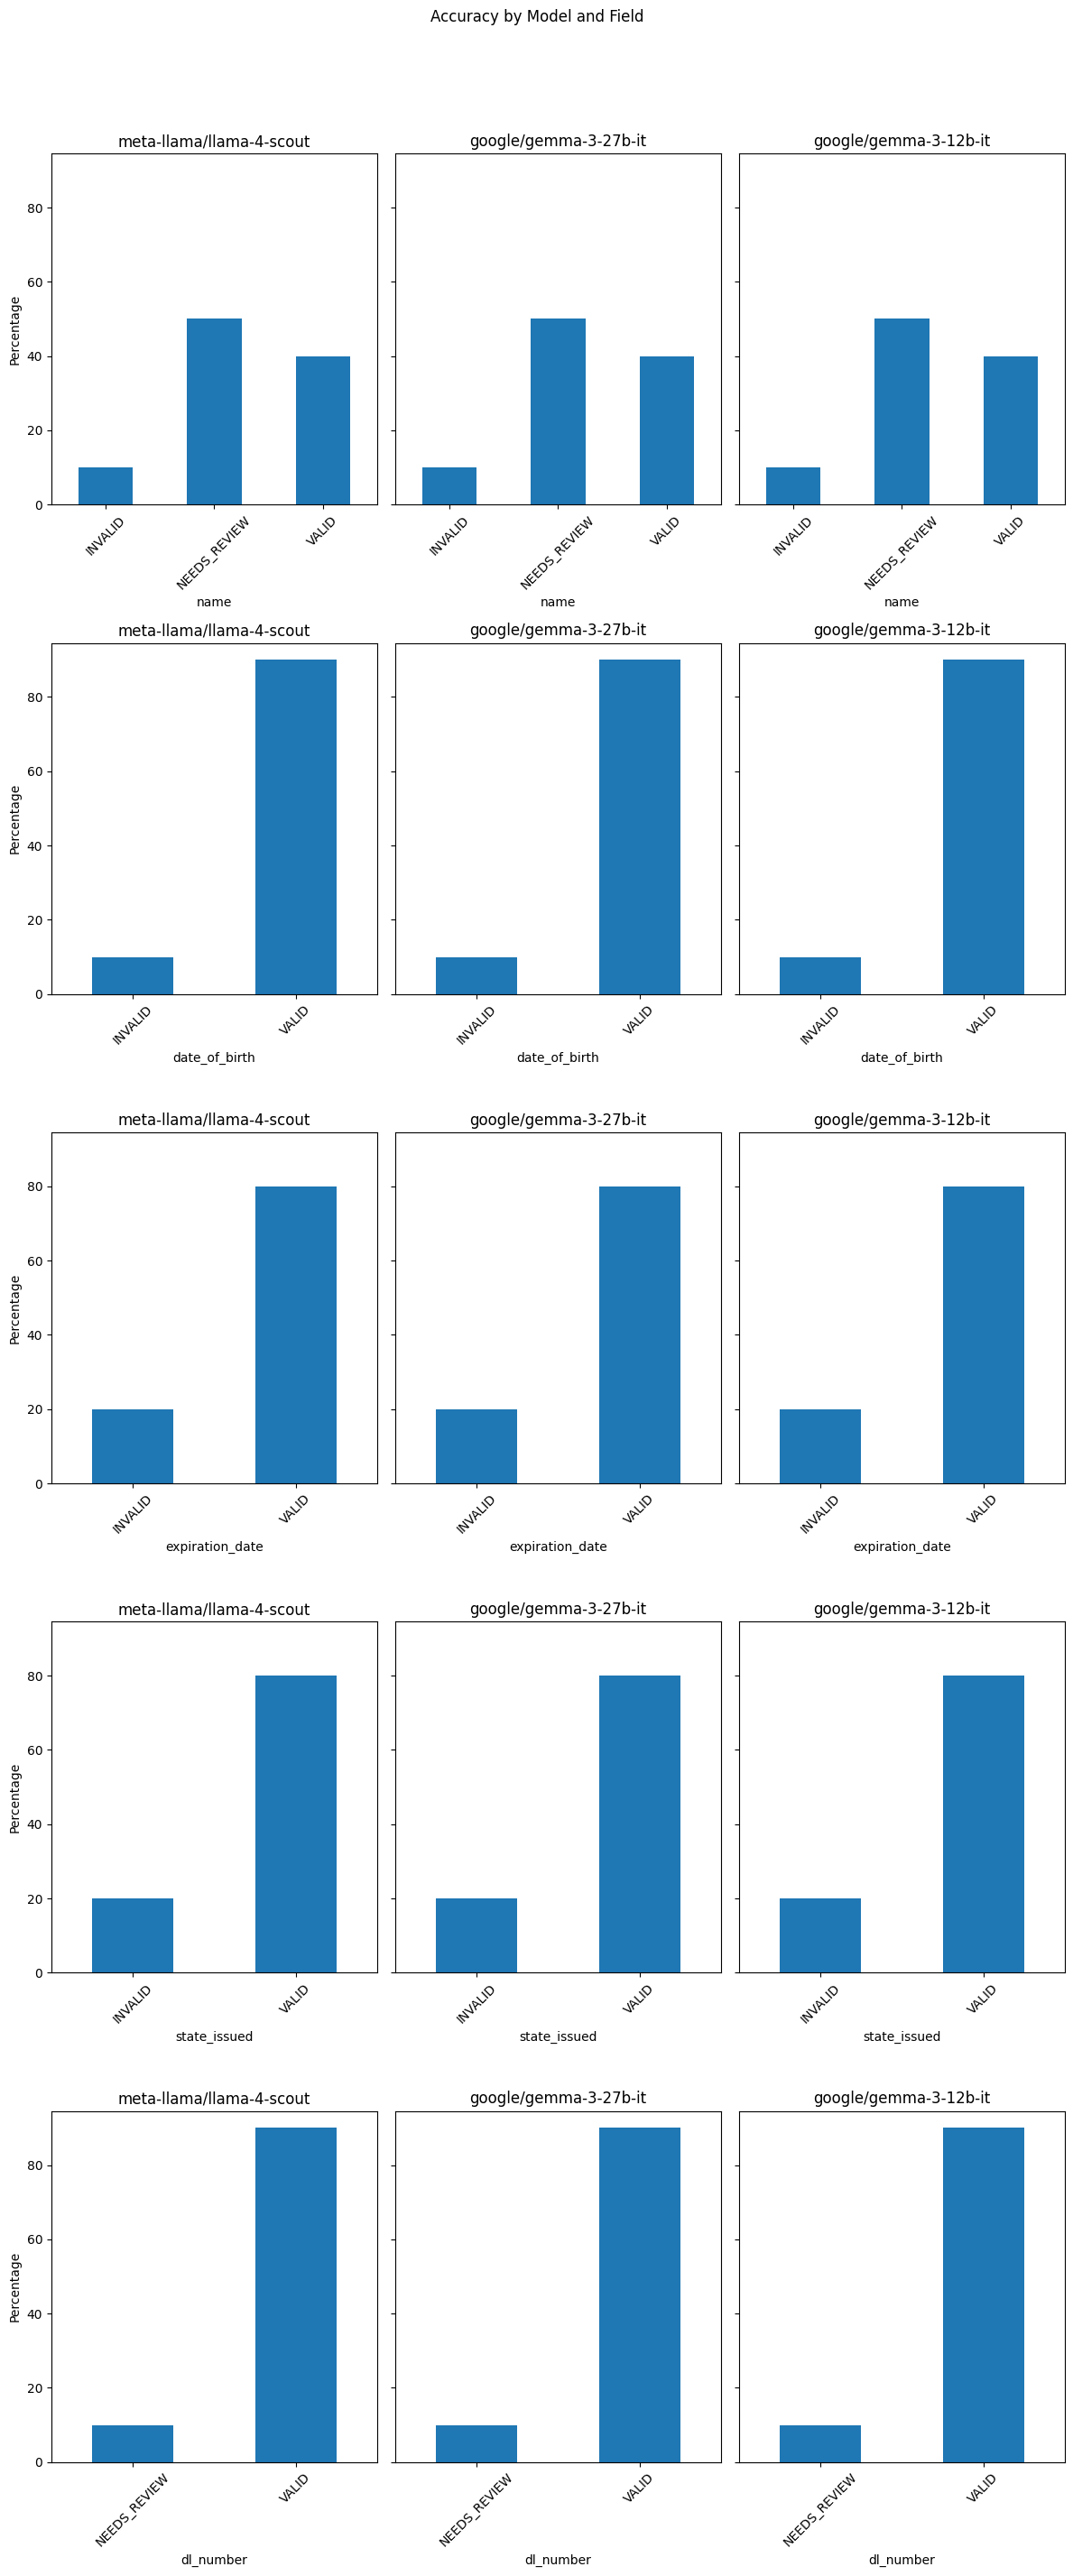

In [8]:
vision_models = ["LLAMASCOUT4", "GEMMA27B", "GEMMA12B"]

target_dir = "reports"
    
datasets = []

##############################################################################
# Generate Extracted Data and Evaluations
##############################################################################
for model_prefix in vision_models:

    try:

        df = extract_license_info("https://github.com/agapebondservant/dla_poc", "notebooks/data2", model_prefix)

        datasets.append(df)

    except Exception as e:

        print(f"Error occurred while processing with model {model_prefix}: e")

        traceback.print_exc()

##############################################################################
# Generate Reports
##############################################################################
combined_df = pd.concat(datasets)

transformed_df = utils.data_report_prep(combined_df)

utils.generate_csv_report(transformed_df, target_dir)

utils.generate_jsonl_report(transformed_df, target_dir)

reporting_df = transformed_df.filter(regex='^eval_|model_name') 

utils.generate_visualizatioms(reporting_df, target_dir)

In [9]:
transformed_df

,application_id,image_path,name,date_of_birth,expiration_date,dl_number,state_issued,model_name,extracted_name,extracted_date_of_birth,extracted_expiration_date,extracted_issuance_date,extracted_state_issued,extracted_dl_number,extracted_photo_orientation,eval_name,eval_date_of_birth,eval_expiration_date,eval_state_issued,eval_dl_number
0,DENVER-25CAP-00000-04SUF,https://raw.githubusercontent.com/agapebondser...,"Mook, Dada Lainne",1954-07-29 00:00:00,2028-07-29 00:00:00,94-223-0294,Colorado,openrouter/meta-llama/llama-4-scout,MOOKe DADALAINNE,07/29/1954,07/29/2028,01/25/2023,COLORADO,94-223-0294,Upright,NEEDS_REVIEW,VALID,VALID,VALID,VALID
1,DENVER-25CAP-00000-04SVL,https://raw.githubusercontent.com/agapebondser...,WILLIAM BLAST,1967-07-18 00:00:00,2029-07-18 00:00:00,14-197-1414,Colorado,openrouter/meta-llama/llama-4-scout,William Blast,07/18/1967,07/18/2029,12/10/2024,COLORADO,14-197-1414,not skewed,VALID,VALID,VALID,VALID,VALID
2,DENVER-25CAP-00000-04SWA,https://raw.githubusercontent.com/agapebondser...,Pat Ratanaf,1975-12-06 00:00:00,2029-12-06 00:00:00,17-176-1768,Colorado,openrouter/meta-llama/llama-4-scout,RATANAF PAT,12/06/1975,12/06/2029,01/18/2024,COLORADO,17-176-1768,not skewed,NEEDS_REVIEW,VALID,VALID,VALID,VALID
3,DENVER-25CAP-00000-04SZC,https://raw.githubusercontent.com/agapebondser...,WILLI MILLIAM NAN,1983-04-05 00:00:00,2028-04-05 00:00:00,Y68519,Colorado,openrouter/meta-llama/llama-4-scout,WILLI MILLIAM NAN,04/05/1983,04/05/2028,01/24/2023,California,Y68519,Not skewed,VALID,VALID,VALID,INVALID,VALID
4,DENVER-25CAP-00000-04TEE,https://raw.githubusercontent.com/agapebondser...,Beety Mam Kutrum,1949-09-21 00:00:00,2025-09-21 00:00:00,94-263-6383,Colorado,openrouter/meta-llama/llama-4-scout,KUTRUM BEETY MAM,09/21/1949,09/21/2025,07/17/2020,COLORADO,94-263-6383,not skewed,VALID,VALID,VALID,VALID,VALID
5,DENVER-25CAP-00000-04TFN,https://raw.githubusercontent.com/agapebondser...,Gel el Rathree Nee,1981-02-02 00:00:00,2026-02-02 00:00:00,96-176-1217,Colorado,openrouter/meta-llama/llama-4-scout,Gel El Rathree Nee,02/02/1981,02/02/2026,07/30/2021,COLORADO,96-176-1217,not skewed,VALID,VALID,VALID,VALID,VALID
6,DENVER-25CAP-00000-04TIP,https://raw.githubusercontent.com/agapebondser...,MICHI CHARI ARLES,1969-05-27 00:00:00,2029-05-27 00:00:00,99-064-0671,Colorado,openrouter/meta-llama/llama-4-scout,Arles Michi Chari,05/27/1969,05/27/2029,08/05/2024,COLORADO,99-064-0671,not skewed,NEEDS_REVIEW,VALID,VALID,VALID,VALID
7,DENVER-25CAP-00000-04TIV,https://raw.githubusercontent.com/agapebondser...,VID COURT,1979-11-13 00:00:00,2030-11-13 00:00:00,13-227-0822,Colorado,openrouter/meta-llama/llama-4-scout,CONNELLY VID COURT,11/13/1979,11/13/2030,04/16/2025,COLORADO,13-227-0822,Not skewed,NEEDS_REVIEW,VALID,VALID,VALID,VALID
8,DENVER-25CAP-00000-04TJX,https://raw.githubusercontent.com/agapebondser...,ANNLEY WALLS,1967-07-18 00:00:00,2029-07-18 00:00:00,086996911,Tennessee,openrouter/meta-llama/llama-4-scout,ANN LEY ANN WALLS,02/07/1979,02/05/2027,10/19/2023,Tennessee,086996911,not skewed,NEEDS_REVIEW,INVALID,INVALID,VALID,VALID
9,DENVER-25CAP-00000-04TK7,https://raw.githubusercontent.com/agapebondser...,AUG BURGESS,1999-05-05 00:00:00,2031-05-05 00:00:00,48486236,Colorado,openrouter/meta-llama/llama-4-scout,SUMMIT C MONE,05/05/1999,08/06/2023,Not provided,Texas,48486336,Not skewed,INVALID,VALID,INVALID,INVALID,NEEDS_REVIEW
